# Gazania vs GasTurb

Comparison of Gazania with GasTurb, for the same cycle. The GasTurb file is available in misc/GasTurbExample.CYG.

#### Notes: 
GasTurb usually assumes a converging nozzle for both bypass and core streams. However, their converging nozzle model does not always choose M = 1 at outlet. Instead, it first does an isentropic expansion to ambient pressure, and if the exit velocity is subsonic, it uses this subsonic solution. If it is supersonic, it limits the exit velocity to M = 1. 

Gazania uses the same method with `Nozzle(type = 'C')`.

The perfect gas model actually produces an unchoked core nozzle with this method, due to the very large errors in turbine pressure ratios, which brings the nozzle inlet pressure close to atmospheric (leaving it with little extra pressure ratio to expand over).

### References:
[1] - GasTurb14 Manual (https://www.gasturb.de/Downloads/Manuals/GasTurb14.pdf)


In [1]:
import gazania as gaz
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 130

#### Operating points:

In [2]:
# Inlet conditions
T_in = 288.15
p_in = 101325
V_in = 0.0
mdot_in = 410
BPR = 12

# Core cycle
LPC_core = gaz.Compressor(PR = 1.25, isen = 0.87)
IPC = gaz.Compressor(PR = 2.5, isen = 0.84)
HPC = gaz.Compressor(PR = 15, isen = 0.85)
burner_T_out = 1700                             # We will need to vary the fuel mass flow rate until we get the desired T_out
burner_PR = 0.95
LCV = 43e6
HPT_isen = 0.87                                 # The turbines pressure ratios must be chosen to balance the shaft powers
LPT_isen = 0.90
core_nozzle = gaz.Nozzle(type = "C", p_amb = p_in)

# Bypass cycle
LPC_bypass = gaz.Compressor(PR = 1.3, isen = 0.91)
bypass_nozzle = gaz.Nozzle(type = "C", p_amb = p_in)

#### Solve using Gazania (with Cantera model):

$C_{14}H_{28} + \frac{21}{\phi}(O_2 + \frac{0.79}{0.21}N_2) --> 14CO_2 + 14H_2O + \frac{79}{\phi}N_2 + (\frac{21}{\phi} - 42)O_2$

$\phi = \dot{m}_f / \dot{m}_{f, stoich}$

$\dot{m}_{f, stoich} = \dot{m}_{a} \times \frac{7}{103}$


In [3]:
# Model for fuel
gri30 = ct.Solution('gri30.xml')

#From the GasTurb manual (Reference [1], Section 5.1.2 - 'Fuel'), kerosene Y = C:86.08, H:13.92. This leads to
# X = C:7.17, H:13.92. We will approximate this as C14H28.

mdot_air_core = mdot_in / (BPR + 1)
mdot_f_stoich = mdot_air_core * 7 / 103

# Iterate until we find the fuel mass flow rate required
def errors(f_HPT_LPT):
    global turbofan_ct
    
    mdot_f = f_HPT_LPT[0]
    HPT_PR = f_HPT_LPT[1]
    LPT_PR = f_HPT_LPT[2]
    
    # Calculate products for complete combustion
    phi = mdot_f / mdot_f_stoich
    products = ct.Quantity(gri30, mass = mdot_air_core + mdot_f)
    products.X = f"CO2:14, H2O:14, N2:{79/phi}, O2: {(21/phi - 42)}"
    
    reactants_out = gaz.BleedOut(mdot_out = mdot_air_core)
    products_in = gaz.Mixer(fluid = products, ignore_T = True, ignore_p = True)
    heat_in = gaz.HeatExchanger(Qdot = mdot_f * LCV, PR = burner_PR)
    HP_equilibrium = gaz.Equilibrium(constant = "HP")
    
    HPT = gaz.Turbine(PR = HPT_PR, isen = HPT_isen)
    LPT = gaz.Turbine(PR = LPT_PR, isen = LPT_isen)

    # Set up turbofan and vary turbine PR until the powers balance
    core_components = [LPC_core, 
                       IPC, 
                       HPC, 
                       reactants_out,
                       products_in,
                       heat_in,
                       HP_equilibrium,
                       HPT, 
                       LPT, 
                       core_nozzle]
    
    bypass_components = [LPC_bypass, 
                         bypass_nozzle]

    turbofan_ct = gaz.engine.Turbofan(mdot_in = mdot_in,
                                      BPR = BPR,
                                      bypass_components = bypass_components,
                                      core_components = core_components,
                                      p_in = p_in,
                                      T_in = T_in,
                                      V_in = V_in,
                                      model = "cantera")
    turbofan_ct.solve()
    
    burner_T_error = turbofan_ct.core_cycle.T[6] - burner_T_out
    
    LP_compressor_power = turbofan_ct.core_compressor_powers[0] + turbofan_ct.core_compressor_powers[1] + turbofan_ct.bypass_compressor_powers[0]
    LP_turbine_power = turbofan_ct.core_turbine_powers[1]
    LP_power_error = LP_compressor_power + LP_turbine_power
    
    HP_compressor_power = turbofan_ct.core_compressor_powers[2]
    HP_turbine_power = turbofan_ct.core_turbine_powers[0]
    HP_power_error = HP_compressor_power + HP_turbine_power
    
    return [burner_T_error, LP_power_error, HP_power_error]

root = scipy.optimize.fsolve(errors, x0 = [1, 5, 5])

mdot_f_ct = root[0]
HPT_PR_ct = root[1]
LPT_PR_ct = root[2]

print(f"""
CONVERGED ON:
-------------
mdot_f = {mdot_f_ct} kg/s
PR for HPT = {HPT_PR_ct}
PR for LPT = {LPT_PR_ct}

Power imbalance = {turbofan_ct.net_power} W

Thrust = {turbofan_ct.thrust/1e3} kN""")


CONVERGED ON:
-------------
mdot_f = 0.7041999255329888 kg/s
PR for HPT = 4.671481744365249
PR for LPT = 4.580548184275914

Power imbalance = -1.4901161193847656e-08 W

Thrust = 99.48060948373741 kN


#### Solve using Gazania (with perfect gas model):

In [4]:
# Model for fuel
gri30 = ct.Solution('gri30.xml')
fuel = ct.Quantity(gri30)
fuel.TPY = 298, 1e5, "C:86.08, H:13.92"    # From the GasTurb manual (Reference [1], Section 5.1.2 - 'Fuel')

# Iterate until we find the fuel mass flow rate required
def errors(f_HPT_LPT):
    global turbofan_pg
    
    mdot_f = f_HPT_LPT[0]
    HPT_PR = f_HPT_LPT[1]
    LPT_PR = f_HPT_LPT[2]
    
    change_properties = gaz.ChangeProperties(new_cp = 1100, 
                                             new_gamma = 1.333, 
                                             new_mdot = mdot_f + mdot_in/(BPR + 1))
    
    heat_in = gaz.HeatExchanger(Qdot = mdot_f * LCV, PR = burner_PR)
    
    HPT = gaz.Turbine(PR = HPT_PR, isen = HPT_isen)
    LPT = gaz.Turbine(PR = LPT_PR, isen = LPT_isen)

    # Set up turbofan and vary turbine PR until the powers balance
    core_components = [LPC_core, 
                       IPC, 
                       HPC, 
                       change_properties,
                       heat_in,
                       HPT, 
                       LPT, 
                       core_nozzle]
    
    bypass_components = [LPC_bypass, 
                         bypass_nozzle]

    turbofan_pg = gaz.engine.Turbofan(mdot_in = mdot_in,
                                      BPR = BPR,
                                      bypass_components = bypass_components,
                                      core_components = core_components,
                                      p_in = p_in,
                                      T_in = T_in,
                                      V_in = V_in,
                                      model = "perfect")
    turbofan_pg.solve()
    
    burner_T_error = turbofan_pg.core_cycle.T[5] - burner_T_out    # Note index is different to the CT case!
    
    LP_compressor_power = turbofan_pg.core_compressor_powers[0] + turbofan_pg.core_compressor_powers[1] + turbofan_pg.bypass_compressor_powers[0]
    LP_turbine_power = turbofan_pg.core_turbine_powers[1]
    LP_power_error = LP_compressor_power + LP_turbine_power
    
    HP_compressor_power = turbofan_pg.core_compressor_powers[2]
    HP_turbine_power = turbofan_pg.core_turbine_powers[0]
    HP_power_error = HP_compressor_power + HP_turbine_power
    
    return [burner_T_error, LP_power_error, HP_power_error]

root = scipy.optimize.fsolve(errors, x0 = [1, 5, 5])

mdot_f_pg = root[0]
HPT_PR_pg = root[1]
LPT_PR_pg = root[2]

print(f"""
CONVERGED ON:
-------------
mdot_f = {mdot_f_pg} kg/s
PR for HPT = {HPT_PR_pg}
PR for LPT = {LPT_PR_pg}

Power imbalance = {turbofan_pg.net_power} W

Thrust = {turbofan_pg.thrust/1e3} kN""")


CONVERGED ON:
-------------
mdot_f = 0.5767716120087094 kg/s
PR for HPT = 5.622427358649397
PR for LPT = 6.00815275715543

Power imbalance = -4.76837158203125e-07 W

Thrust = 91.43648808212878 kN


#### Extract the data that was generated by GasTurb.

In [5]:
# Note the GasTurb data does not include the nozzle exit conditions
with open('misc\GasTurbExample.txt') as f:
    gt_data = f.readlines()

core_lines = range(7, 22)
T_core_gt = np.zeros(len(core_lines) + 1)
p_core_gt = np.zeros(len(core_lines) + 1)

T_bypass_gt = np.array([float(gt_data[5][18:25]), float(gt_data[7][18:25])])
p_bypass_gt = np.array([float(gt_data[5][27:35]), float(gt_data[7][27:35])]) * 1e3

T_core_gt[0] = float(gt_data[5][18:25])
p_core_gt[0] = float(gt_data[5][27:35]) * 1e3



for i in range(len(core_lines)):
    line = core_lines[i]
    T_core_gt[i+1] = float(gt_data[line][18:25])
    p_core_gt[i+1] = float(gt_data[line][27:35]) * 1e3

mdot_f_gt = float(gt_data[14][8:16]) - float(gt_data[13][8:16])   # Fuel mass flow rate (kg/s)
thrust_gt = float(gt_data[4][64:72]) * 1e3                        # Total thrust (N)
HPT_PR_gt = p_core_gt[9] / p_core_gt[10]                          # HPT pressure ratio
LPT_PR_gt = p_core_gt[12] / p_core_gt[13]                         # LPT pressure ratio
A_e_c_gt = float(gt_data[19][64:72])                              # Core nozzle exit area (m2)
A_e_b_gt = float(gt_data[20][64:72])                              # Bypass nozzle exit area (m2)

#print("CORE CYCLE \n----------")
#for i in range(len(T_core_gt)):
#    print(f"i = {i}    T = {T_core_gt[i]:.2f} K    p = {p_core_gt[i]/1e3:.3f} kPa")
    
#print("\n BYPASS CYCLE \n ------------")
#for i in range(len(T_bypass_gt)):
#    print(f"i = {i}    T = {T_bypass_gt[i]:.2f} K    p = {p_bypass_gt[i]/1e3:.3f} kPa")

In [6]:
print(f"""
ERRORS (CANTERA)
---------------
Thrust = {(turbofan_ct.thrust - thrust_gt) / thrust_gt * 100} %
Fuel flow rate = {(mdot_f_ct - mdot_f_gt) / mdot_f_gt * 100} %
HPT PR = {(HPT_PR_ct - HPT_PR_gt)/HPT_PR_gt * 100} %
LPT PR = {(LPT_PR_ct - LPT_PR_gt)/LPT_PR_gt * 100} %
Core nozzle area = {(turbofan_ct.A_e_c - A_e_c_gt) / A_e_c_gt * 100} %
Bypass nozzle area = {(turbofan_ct.A_e_b - A_e_b_gt) / A_e_b_gt * 100} %

ERRORS (PERFECT GAS)
--------------------
Thrust = {(turbofan_pg.thrust - thrust_gt) / thrust_gt * 100} %
Fuel flow rate = {(mdot_f_pg - mdot_f_gt) / mdot_f_gt * 100} %
HPT PR = {(HPT_PR_pg - HPT_PR_gt)/HPT_PR_gt * 100} %
LPT PR = {(LPT_PR_pg - LPT_PR_gt)/LPT_PR_gt * 100} %
Core nozzle area = {(turbofan_pg.A_e_c - A_e_c_gt) / A_e_c_gt * 100} %
Bypass nozzle area = {(turbofan_pg.A_e_b - A_e_b_gt) / A_e_b_gt * 100} %
""")


ERRORS (CANTERA)
---------------
Thrust = 0.33344375566052564 %
Fuel flow rate = -3.002765078101066 %
HPT PR = -1.7974316661261993 %
LPT PR = -2.569660171321296 %
Core nozzle area = -3.344501724100682 %
Bypass nozzle area = 0.016626466329132943 %

ERRORS (PERFECT GAS)
--------------------
Thrust = -7.779638848079898 %
Fuel flow rate = -20.554874378965934 %
HPT PR = 18.193078150417165 %
LPT PR = 27.796137344814735 %
Core nozzle area = 56.56484605452257 %
Bypass nozzle area = 0.026675733376515062 %



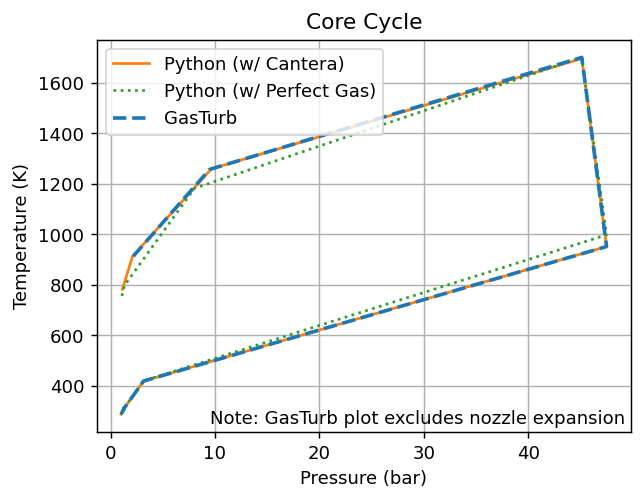

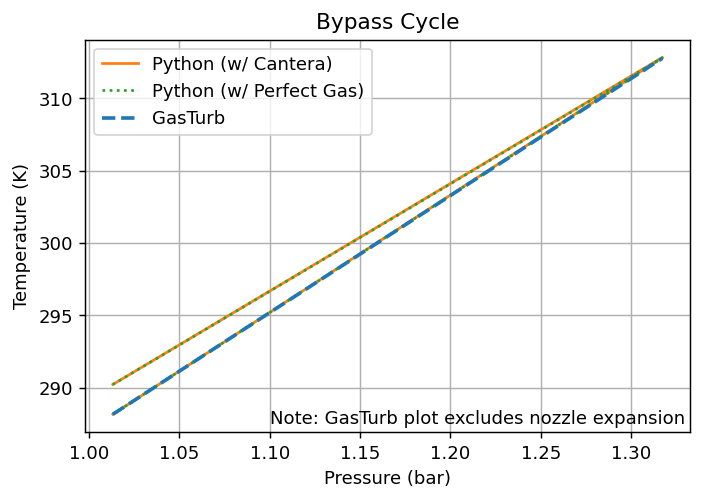

In [7]:
from matplotlib.pyplot import figure
figure(figsize=(5.3, 4))

plt.title("Core Cycle")
plt.plot(turbofan_ct.core_cycle.p/1e5, turbofan_ct.core_cycle.T, label = "Python (w/ Cantera)", color = "C1")
plt.plot(turbofan_pg.core_cycle.p/1e5, turbofan_pg.core_cycle.T, linestyle = "dotted", label = "Python (w/ Perfect Gas)", color = "C2")
plt.plot(p_core_gt/1e5, T_core_gt, linewidth = 2, linestyle = "--", label = "GasTurb", color = "C0")
plt.xlabel("Pressure (bar)")
plt.ylabel("Temperature (K)")
plt.text(9.5, 250, "Note: GasTurb plot excludes nozzle expansion")
plt.grid()
plt.legend(loc = "upper left")

plt.savefig("img/gazania_gasturb_core_dissociation.svg")
plt.show()


plt.title("Bypass Cycle")
plt.plot(turbofan_ct.bypass_cycle.p/1e5, turbofan_ct.bypass_cycle.T, label = "Python (w/ Cantera)", color = "C1")
plt.plot(turbofan_pg.bypass_cycle.p/1e5, turbofan_pg.bypass_cycle.T, linestyle = "dotted", label = "Python (w/ Perfect Gas)", color = "C2")
plt.plot(p_bypass_gt/1e5, T_bypass_gt, linewidth = 2, linestyle = "--", label = "GasTurb", color = "C0")
plt.xlabel("Pressure (bar)")
plt.ylabel("Temperature (K)")
plt.text(1.1, 287.5, "Note: GasTurb plot excludes nozzle expansion")
plt.grid()
plt.legend()
plt.savefig("img/gazania_gasturb_bypass.svg")
plt.show()